# TensorFlow script mode training and serving

Script mode is a training script format for TensorFlow that lets you execute any TensorFlow training script in SageMaker with minimal modification. The [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk) handles transferring your script to a SageMaker training instance. On the training instance, SageMaker's native TensorFlow support sets up training-related environment variables and executes your training script. In this tutorial, we use the SageMaker Python SDK to launch a training job and deploy the trained model.

Script mode supports training with a Python script, a Python module, or a shell script. In this example, we use a Python script to train a classification model on the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). In addition, this notebook demonstrates how to perform real time inference with the [SageMaker TensorFlow Serving container](https://github.com/aws/sagemaker-tensorflow-serving-container). The TensorFlow Serving container is the default inference method for script mode. For full documentation on the TensorFlow Serving container, please visit [here](https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/tensorflow/deploying_tensorflow_serving.rst).


# Set up the environment

Let's start by setting up the environment:

In [1]:
import os
import sagemaker
from sagemaker import get_execution_role
import time

sagemaker_session = sagemaker.Session()

role = get_execution_role()
region = sagemaker_session.boto_session.region_name

## Training Data

The MNIST dataset has been loaded to the public S3 buckets ``sagemaker-sample-data-<REGION>`` under the prefix ``tensorflow/mnist``. There are four ``.npy`` file under this prefix:
* ``train_data.npy``
* ``eval_data.npy``
* ``train_labels.npy``
* ``eval_labels.npy``

In [2]:
training_data_uri = 's3://sagemaker-sample-data-{}/tensorflow/mnist'.format(region)

# Construct a script for distributed training

This tutorial's training script was adapted from TensorFlow's official [CNN MNIST example](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/layers/cnn_mnist.py). We have modified it to handle the ``model_dir`` parameter passed in by SageMaker. This is an S3 path which can be used for data sharing during distributed training and checkpointing and/or model persistence. We have also added an argument-parsing function to handle processing training-related variables.

At the end of the training job we have added a step to export the trained model to the path stored in the environment variable ``SM_MODEL_DIR``, which always points to ``/opt/ml/model``. This is critical because SageMaker uploads all the model artifacts in this folder to S3 at end of training.

For more documentation on SageMaker 'script' mode, please, refer to https://sagemaker.readthedocs.io/en/stable/using_tf.html

Here is the entire script:

In [3]:
!pygmentize 'mnist.py'

# Copyright 2018-2019 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License"). You
# may not use this file except in compliance with the License. A copy of
# the License is located at
#
#     http://aws.amazon.com/apache2.0/
#
# or in the "license" file accompanying this file. This file is
# distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF
# ANY KIND, either express or implied. See the License for the specific
# language governing permissions and limitations under the License.
"""Convolutional Neural Network Estimator for MNIST, built with tf.layers."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import os
import json
import argparse
from tensorflow.python.platform import tf_logging
import logging as _logging
import sys as _sys


def cnn_model_fn(features, labels, mode):
    """Model functio

# Create a training job using the `TensorFlow` estimator

The `sagemaker.tensorflow.TensorFlow` estimator handles locating the script mode container, uploading your script to a S3 location and creating a SageMaker training job. Let's call out a couple important parameters here:

* `py_version` is set to `'py3'` to indicate that we are using script mode since legacy mode supports only Python 2. Though Python 2 will be deprecated soon, you can use script mode with Python 2 by setting `py_version` to `'py2'` and `script_mode` to `True`.

* `distributions` is used to configure the distributed training setup. It's required only if you are doing distributed training either across a cluster of instances or across multiple GPUs. Here we are using parameter servers as the distributed training schema. SageMaker training jobs run on homogeneous clusters. To make parameter server more performant in the SageMaker setup, we run a parameter server on every instance in the cluster, so there is no need to specify the number of parameter servers to launch. Script mode also supports distributed training with [Horovod](https://github.com/horovod/horovod). You can find the full documentation on how to configure `distributions` [here](https://github.com/aws/sagemaker-python-sdk/tree/master/src/sagemaker/tensorflow#distributed-training). 




In [4]:
from sagemaker.tensorflow import TensorFlow
train_instance_count = 2
#train_instance_type = 'ml.p2.xlarge' 
#train_instance_type='ml.c5.9xlarge'
train_instance_type='ml.m4.4xlarge'
#train_instance_type='ml.m5.2xlarge'
#train_instance_type='ml.m5.4xlarge'
#train_instance_type='ml.c4.2xlarge'
#train_instance_type='ml.c5.2xlarge'

mnist_estimator = TensorFlow(entry_point='mnist.py',
                             role=role,
                             train_instance_count=train_instance_count,
                             train_instance_type=train_instance_type,
                             framework_version='1.12',
                             py_version = 'py3',
                             distributions = {'parameter_server': {'enabled': True}})

## Calling ``fit``

To start a training job, we call `estimator.fit(training_data_uri)`.

An S3 location is used here as the input. `fit` creates a default channel named `'training'`, which points to this S3 location. In the training script we can then access the training data from the location stored in `SM_CHANNEL_TRAINING`. `fit` accepts a couple other types of input as well. See the API doc [here](https://sagemaker.readthedocs.io/en/stable/estimators.html#sagemaker.estimator.EstimatorBase.fit) for details.

When training starts, the TensorFlow container executes mnist.py, passing `hyperparameters` and `model_dir` from the estimator as script arguments. Because we didn't define either in this example, no hyperparameters are passed, and `model_dir` defaults to `s3://<DEFAULT_BUCKET>/<TRAINING_JOB_NAME>`, so the script execution is as follows:
```bash
python mnist.py --model_dir s3://<DEFAULT_BUCKET>/<TRAINING_JOB_NAME>
```
When training is complete, the training job will upload the saved model for TensorFlow serving.

In [ ]:
%%time
print("train_instance_type - ",train_instance_type )
mnist_estimator.fit(training_data_uri)

# Deploy the trained model to an endpoint

The `deploy()` method creates a SageMaker model, which is then deployed to an endpoint to serve prediction requests in real time. We will use the TensorFlow Serving container for the endpoint, because we trained with script mode. This serving container runs an implementation of a web server that is compatible with SageMaker hosting protocol. The [Using your own inference code]() document explains how SageMaker runs inference containers.

In [6]:
%%time
#instance_type_predict = 'ml.c5.9xlarge'
host_instance_type = 'ml.m4.xlarge'
predictor = mnist_estimator.deploy(initial_instance_count=1, instance_type=host_instance_type)

---------------------------------------------------------------------------!CPU times: user 383 ms, sys: 26.3 ms, total: 410 ms
Wall time: 6min 20s


# Invoke the endpoint

Let's download the training data and use that as input for inference.

In [7]:
import numpy as np

!aws --region {region} s3 cp s3://sagemaker-sample-data-{region}/tensorflow/mnist/train_data.npy train_data.npy
!aws --region {region} s3 cp s3://sagemaker-sample-data-{region}/tensorflow/mnist/train_labels.npy train_labels.npy

train_data = np.load('train_data.npy')
train_labels = np.load('train_labels.npy')

download: s3://sagemaker-sample-data-us-east-1/tensorflow/mnist/train_data.npy to ./train_data.npy
download: s3://sagemaker-sample-data-us-east-1/tensorflow/mnist/train_labels.npy to ./train_labels.npy


The formats of the input and the output data correspond directly to the request and response formats of the `Predict` method in the [TensorFlow Serving REST API](https://www.tensorflow.org/serving/api_rest). SageMaker's TensforFlow Serving endpoints can also accept additional input formats that are not part of the TensorFlow REST API, including the simplified JSON format, line-delimited JSON objects ("jsons" or "jsonlines"), and CSV data.

In this example we are using a `numpy` array as input, which will be serialized into the simplified JSON format. In addtion, TensorFlow serving can also process multiple items at once as you can see in the following code. You can find the complete documentation on how to make predictions against a TensorFlow serving SageMaker endpoint [here](https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/tensorflow/deploying_tensorflow_serving.rst#making-predictions-against-a-sagemaker-endpoint).

prediction is 7, label is 7, matched: True
prediction is 3, label is 3, matched: True
prediction is 4, label is 4, matched: True
prediction is 6, label is 6, matched: True
prediction is 1, label is 1, matched: True
prediction is 8, label is 8, matched: True
prediction is 1, label is 1, matched: True
prediction is 0, label is 0, matched: True
prediction is 9, label is 9, matched: True
prediction is 8, label is 8, matched: True
prediction is 0, label is 0, matched: True
prediction is 3, label is 3, matched: True
prediction is 1, label is 1, matched: True
prediction is 3, label is 2, matched: False


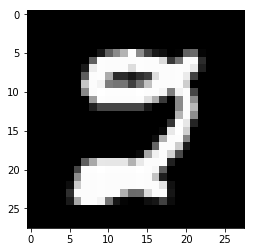

prediction is 7, label is 7, matched: True
prediction is 0, label is 0, matched: True
prediction is 2, label is 2, matched: True
prediction is 9, label is 9, matched: True
prediction is 6, label is 6, matched: True
prediction is 0, label is 0, matched: True
prediction is 1, label is 1, matched: True
prediction is 6, label is 6, matched: True
prediction is 7, label is 7, matched: True
prediction is 1, label is 1, matched: True
prediction is 9, label is 9, matched: True
prediction is 7, label is 7, matched: True
prediction is 6, label is 6, matched: True
prediction is 5, label is 5, matched: True
prediction is 5, label is 5, matched: True
prediction is 8, label is 8, matched: True
prediction is 8, label is 8, matched: True
prediction is 3, label is 3, matched: True
prediction is 4, label is 4, matched: True
prediction is 4, label is 4, matched: True
prediction is 8, label is 8, matched: True
prediction is 7, label is 7, matched: True
prediction is 3, label is 3, matched: True
prediction 

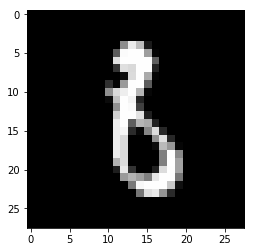

prediction is 8, label is 8, matched: True
prediction is 9, label is 9, matched: True
prediction is 9, label is 9, matched: True
prediction is 4, label is 4, matched: True
prediction is 4, label is 4, matched: True
prediction is 0, label is 0, matched: True
prediction is 7, label is 7, matched: True
prediction is 8, label is 8, matched: True
prediction is 1, label is 1, matched: True
prediction is 5, label is 0, matched: False


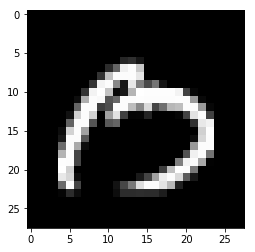

prediction is 0, label is 0, matched: True
prediction is 1, label is 1, matched: True
prediction is 8, label is 8, matched: True
prediction is 5, label is 5, matched: True
prediction is 7, label is 7, matched: True
prediction is 1, label is 1, matched: True
prediction is 7, label is 7, matched: True
prediction is 5, label is 5, matched: True
prediction is 5, label is 5, matched: True
prediction is 9, label is 9, matched: True
prediction is 9, label is 9, matched: True
prediction is 4, label is 4, matched: True
prediction is 2, label is 2, matched: True
prediction is 5, label is 5, matched: True
prediction is 3, label is 3, matched: True
prediction is 0, label is 7, matched: False


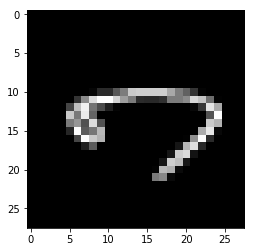

prediction is 4, label is 4, matched: True
prediction is 6, label is 6, matched: True
prediction is 6, label is 6, matched: True
prediction is 0, label is 0, matched: True
prediction is 1, label is 1, matched: True
prediction is 0, label is 0, matched: True
prediction is 1, label is 1, matched: True
prediction is 2, label is 2, matched: True
prediction is 4, label is 4, matched: True
prediction is 8, label is 8, matched: True
prediction is 5, label is 5, matched: True
prediction is 3, label is 3, matched: True
prediction is 5, label is 5, matched: True
prediction is 0, label is 0, matched: True
prediction is 0, label is 0, matched: True
prediction is 6, label is 6, matched: True
prediction is 4, label is 4, matched: True
prediction is 3, label is 3, matched: True
prediction is 8, label is 8, matched: True
prediction is 3, label is 3, matched: True
prediction is 7, label is 7, matched: True
prediction is 1, label is 1, matched: True
prediction is 4, label is 4, matched: True
prediction 

In [10]:
import matplotlib.pyplot as plt
predictions = predictor.predict(train_data[:100])
for i in range(0, 100):
    prediction = predictions['predictions'][i]['classes']
    label = train_labels[i]
    print('prediction is {}, label is {}, matched: {}'.format(prediction, label, prediction == label))
    if (prediction != label):
        plotData = train_data[i]
        plotData = plotData.reshape(28, 28)
        plt.gray() # use this line if you don't want to see it in color
        plt.imshow(plotData)
        plt.show()

# Delete the endpoint

Let's delete the endpoint we just created to prevent incurring any extra costs.

In [9]:
#%%time
#sagemaker.Session().delete_endpoint(predictor.endpoint)